In [1]:
import sys 

sys.path.append('/pl/active/banich/studies/Relevantstudies/abcd/env/lib/python3.7/site-packages')
sys.path.append('/pl/active/banich/studies/Clearvale/jake_scripts/Amy_flywheel_scripts/')

import sys 
import os
import glob
import numpy as np
import scipy.io
import pandas as pd

wm_networks = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_gradients/wm_networks.csv')
wm_networks = wm_networks.reset_index()
wm_networks[['parcel_id']] = wm_networks[['index']] + 1
wm_networks = wm_networks[['parcel_id', 'Subtype']]
net_cols = ['#FCFF0D', '#21DFB4', '#4E00A2', '#F00087']

colors = wm_networks.Subtype.map({1:net_cols[0], 2:net_cols[1], 3:net_cols[2], 4:net_cols[3]})
colors_parcels = colors.reset_index()
colors_parcels[['parcel_id']] = colors_parcels[['index']] + 1
colors_parcels = colors_parcels[['parcel_id', 'Subtype']]

# Assuming these variables are defined elsewhere in your code
group_subs = wm_networks.Subtype
colors = colors_parcels.Subtype

# Define the base path for output directories
base_output_path = '/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/task_gradients/sub/'

class subj_outputs:
    def __init__(self, subject_number, z_matrices):
        self.subject_number = subject_number
        self.path = os.path.join(base_output_path, subject_number)
        os.makedirs(self.path, exist_ok=True)
        self.plot_path = f'{base_output_path}{subject_number}'  # Corrected plot path without subject number
        self.df1 = wm_networks
        self.parcel_index = wm_networks.parcel_id
        self.colors = colors
        self.main_mat = z_matrices.get('maintain')
        self.replace_mat = z_matrices.get('replace')
        self.suppress_mat = z_matrices.get('suppress')
        self.clear_mat = z_matrices.get('clear')


# Base path to your .mat files
base_path = '/pl/active/banich/studies/wmem/fmri/subjects/wmem_results/*/wmem_processing_batch/results/firstlevel/SBC_01/resultsROI_Subject*_Condition00*.mat'

# Get list of all subject directories
subject_dirs = sorted(glob.glob('/pl/active/banich/studies/wmem/fmri/subjects/wmem_results/*'))

# Define the conditions
conditions = {
    'Condition002': 'clear',
    'Condition003': 'maintain',
    'Condition004': 'replace',
    'Condition005': 'suppress'
}

# Dictionary to store Z matrices by subject number and condition
subject_z_matrices = {}

# Process each condition for each subject
for subject_dir in subject_dirs:
    subject_number = os.path.basename(subject_dir)
    print(f'Processing subject: {subject_number}')
    for condition, name in conditions.items():
        subject_path = f'/pl/active/banich/studies/wmem/fmri/subjects/wmem_results/{subject_number}/wmem_processing_batch/results/firstlevel/SBC_01/resultsROI_Subject*_{condition}.mat'
        if glob.glob(subject_path):
            mat_file = glob.glob(subject_path)[0]
            try:
                # Load the .mat file
                mat_contents = scipy.io.loadmat(mat_file)

                # Access the variable 'Z'
                if 'Z' in mat_contents:
                    Z = mat_contents['Z']
                    np.fill_diagonal(Z, 1)
                    if subject_number not in subject_z_matrices:
                        subject_z_matrices[subject_number] = {}
                    subject_z_matrices[subject_number][name] = Z
                    print(f'Processed Subject {subject_number} for {name}')
                else:
                    print(f"Variable 'Z' not found in {mat_file}.")
            except Exception as e:
                print(f"Error processing {mat_file}: {e}")
        else:
            print(f"File not found: {subject_path}")

# Convert to a list if needed
subject_z_list = sorted([(subject, z_matrices) for subject, z_matrices in subject_z_matrices.items()])

# Create instances of subj_outputs for each subject
sub_class_list = [subj_outputs(subject, z_matrices) for subject, z_matrices in subject_z_list]

# Print out paths for verification (optional)
for subj in sub_class_list:
    print(f"Created folder for Subject {subj.subject_number} at {subj.path}")

Processing subject: 001
Processed Subject 001 for clear
Processed Subject 001 for maintain
Processed Subject 001 for replace
Processed Subject 001 for suppress
Processing subject: 002
Processed Subject 002 for clear
Processed Subject 002 for maintain
Processed Subject 002 for replace
Processed Subject 002 for suppress
Processing subject: 004
Processed Subject 004 for clear
Processed Subject 004 for maintain
Processed Subject 004 for replace
Processed Subject 004 for suppress
Processing subject: 005
Processed Subject 005 for clear
Processed Subject 005 for maintain
Processed Subject 005 for replace
Processed Subject 005 for suppress
Processing subject: 006
Processed Subject 006 for clear
Processed Subject 006 for maintain
Processed Subject 006 for replace
Processed Subject 006 for suppress
Processing subject: 008
Processed Subject 008 for clear
Processed Subject 008 for maintain
Processed Subject 008 for replace
Processed Subject 008 for suppress
Processing subject: 009
Processed Subjec

In [2]:
# Create separate lists for each condition
clear_list = []
maintain_list = []
replace_list = []
suppress_list = []

for subject, z_matrices in subject_z_list:
    if 'clear' in z_matrices:
        clear_list.append((subject, z_matrices['clear']))
    if 'maintain' in z_matrices:
        maintain_list.append((subject, z_matrices['maintain']))
    if 'replace' in z_matrices:
        replace_list.append((subject, z_matrices['replace']))
    if 'suppress' in z_matrices:
        suppress_list.append((subject, z_matrices['suppress']))

In [4]:
# Function to compute the average matrix
def compute_average_matrix(matrix_list):
    if len(matrix_list) == 0:
        return None
    # Ensure all elements are numpy arrays
    matrix_list = [m for m in matrix_list if isinstance(m, np.ndarray)]
    sum_matrix = np.sum(matrix_list, axis=0)
    average_matrix = sum_matrix / len(matrix_list)
    return average_matrix

# Compute the average matrices
average_clear_matrix = compute_average_matrix([m[1] for m in clear_list])
average_maintain_matrix = compute_average_matrix([m[1] for m in maintain_list])
average_replace_matrix = compute_average_matrix([m[1] for m in replace_list])
average_suppress_matrix = compute_average_matrix([m[1] for m in suppress_list])


In [7]:
def create_func_mat(data):
    
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import pairwise_distances
    
    X = np.array(data)
    
    #X_Z = (X - np.mean(X, axis=0, keepdims=True)) / np.std(X, axis=0, dtype=np.float64, ddof=1, keepdims=True)
    #D, rho = spearmanr(np.array(X_Z), axis=1)
    D = X
    perc = np.array([np.percentile(x, 90) for x in D])

    for i in range(D.shape[0]):
        D[i, D[i,:] < perc[i]] = 0    
    
    D[D < 0] = 0
    D = 1 - pairwise_distances(D, metric = 'cosine')
    #scaler = MinMaxScaler(feature_range=(.5,1))
    #D = scaler.fit_transform(D)
    
    D = pd.DataFrame(D)
    # D = aff
    
    return(D)

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def save_heatmap(matrix, filename, save_path, cmap='bwr', center=0):
    """
    Creates and saves a heatmap of a given matrix without color bar and no white space.

    Parameters:
    - matrix: The matrix to plot.
    - filename: The name of the file to save (without extension).
    - save_path: The directory where the file will be saved.
    - cmap: The colormap to use (default is 'bwr').
    - center: The value at which to center the colormap (default is 0).
    """
    plt.figure()
    sns.heatmap(matrix, center=center, cmap=cmap, xticklabels=False, yticklabels=False, cbar=False)
    plt.tick_params(left=False, bottom=False)
    plt.gca().set_axis_off()  # Turn off the axis
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)  # Remove white space
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())  # No ticks on X-axis
    plt.gca().yaxis.set_major_locator(plt.NullLocator())  # No ticks on Y-axis
    plt.savefig(save_path + filename + '.png', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()

# Assuming the create_func_mat function has already been defined and works
# Create functional matrices
gmat_main = create_func_mat(average_maintain_matrix)
gmat_replace = create_func_mat(average_replace_matrix)
gmat_suppress = create_func_mat(average_suppress_matrix)
gmat_clear = create_func_mat(average_clear_matrix)

# Save path for figures
save_path = '/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/grp_mats/'

# Save the matrices with heatmaps
save_heatmap(gmat_main, 'gmat_main', save_path)
save_heatmap(gmat_replace, 'gmat_replace', save_path)
save_heatmap(gmat_suppress, 'gmat_suppress', save_path)
save_heatmap(gmat_clear, 'gmat_clear', save_path)


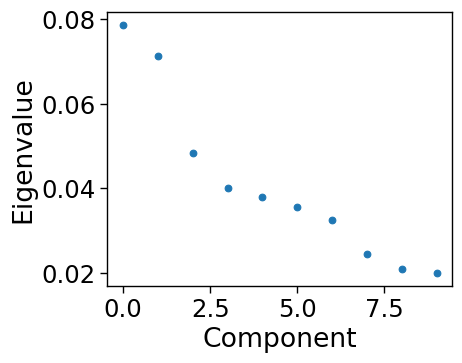

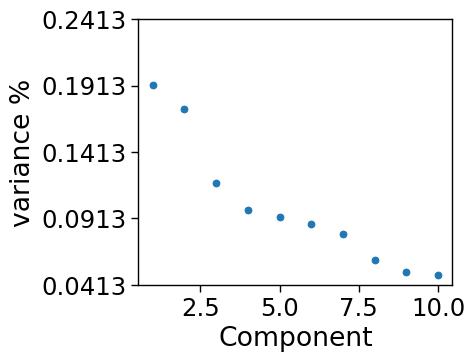

In [20]:
def get_grads(mat_list):
    
    from brainspace.gradient import GradientMaps
    from brainspace.plotting import plot_hemispheres
    from brainspace.utils.parcellation import map_to_labels
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    from brainspace.null_models import SurrogateMaps
    import seaborn as sns
    
    gj = GradientMaps(approach='dm',
                      kernel='normalized_angle',
                      alignment='joint',
                      random_state=1)
    

    global group_grads
    gj_out = gj.fit(mat_list)
    

    for i in range(1):
        sns.set_context("paper", font_scale = 2)
        
        fig, ax = plt.subplots(1, figsize=(5, 4))
        ax.scatter(range(gj_out.lambdas_[i].size), gj_out.lambdas_[i])
        ax.set_xlabel('Component')
        ax.set_ylabel('Eigenvalue')
        fig.tight_layout()
        fig.savefig('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/task_gradients/grp/eigen_components.png')
  
        fig, ax = plt.subplots(1, figsize=(5, 4))
        variance = gj_out.lambdas_[0]
        ax.scatter(range(1,11), variance/variance.sum())
        start, end = ax.get_ylim()
        ax.yaxis.set_ticks(np.arange(start, end+.05, 0.05))
        ax.set_xlabel('Component')
        ax.set_ylabel('variance %')
        variance/variance.sum()
        fig.tight_layout()
        fig.savefig('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/task_gradients/grp/variance_explained.png')
    
    return gj_out


# In[ ]:


gmats = [gmat_main, gmat_replace, gmat_suppress, gmat_clear]
group_grads = get_grads(gmats)

In [21]:
for i in range(4):
    group_grads.aligned_[i][:,1] = group_grads.aligned_[i][:,1]*-1
    #group_grads.aligned_[i][:,2] = group_grads.aligned_[i][:,2]*-1

In [22]:
main_grp_grads = pd.DataFrame(group_grads.aligned_[0]).iloc[:,0:3]
main_grp_grads.columns =['g1', 'g2', 'g3']
main_grp_grads.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/task_gradients/grp/fc_main_grads.csv')

replace_grp_grads = pd.DataFrame(group_grads.aligned_[1]).iloc[:,0:3]
replace_grp_grads.columns =['g1', 'g2', 'g3']
replace_grp_grads.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/task_gradients/grp/fc_replace_grads.csv')

suppress_grp_grads = pd.DataFrame(group_grads.aligned_[2]).iloc[:,0:3]
suppress_grp_grads.columns =['g1', 'g2', 'g3']
suppress_grp_grads.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/task_gradients/grp/fc_suppress_grads.csv')

clear_grp_grads = pd.DataFrame(group_grads.aligned_[3]).iloc[:,0:3]
clear_grp_grads.columns =['g1', 'g2', 'g3']
clear_grp_grads.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/task_gradients/grp/fc_clear_grads.csv')

In [23]:
def align_subs(data):
    
    global group_grads
    
    main_mat_list = create_func_mat(data.main_mat)
    replace_mat_list =  create_func_mat(data.replace_mat)
    suppress_mat_list = create_func_mat(data.suppress_mat)
    clear_mat_list = create_func_mat(data.clear_mat)
    
    gj = GradientMaps(approach='dm', kernel='normalized_angle', alignment='procrustes', random_state=1)
    gj_out_main = gj.fit(np.array(main_mat_list), reference = group_grads.aligned_[0])
    #print('finished main alignment for: ' +  data.name)
    
    gj = GradientMaps(approach='dm', kernel='normalized_angle', alignment='procrustes', random_state=1)
    gj_out_replace = gj.fit(np.array(replace_mat_list), reference =group_grads.aligned_[1])
    #print('finished replace alignment for: ' +  data.name)
    
    gj = GradientMaps(approach='dm', kernel='normalized_angle', alignment='procrustes', random_state=1)
    gj_out_suppress = gj.fit(np.array(suppress_mat_list), reference = group_grads.aligned_[2])
    #print('finished suppress alignment for: ' +  data.name)
    
    gj = GradientMaps(approach='dm', kernel='normalized_angle', alignment='procrustes', random_state=1)
    gj_out_clear = gj.fit(np.array(clear_mat_list), reference = group_grads.aligned_[3])
    #print('finished clear alignment for: ' +  data.name)
        
    data.main_aligned = gj_out_main.aligned_
    data.replace_aligned = gj_out_replace.aligned_
    data.suppress_aligned = gj_out_suppress.aligned_
    data.clear_aligned = gj_out_clear.aligned_
    
    return data


In [24]:
group_grad_df = suppress_grp_grads

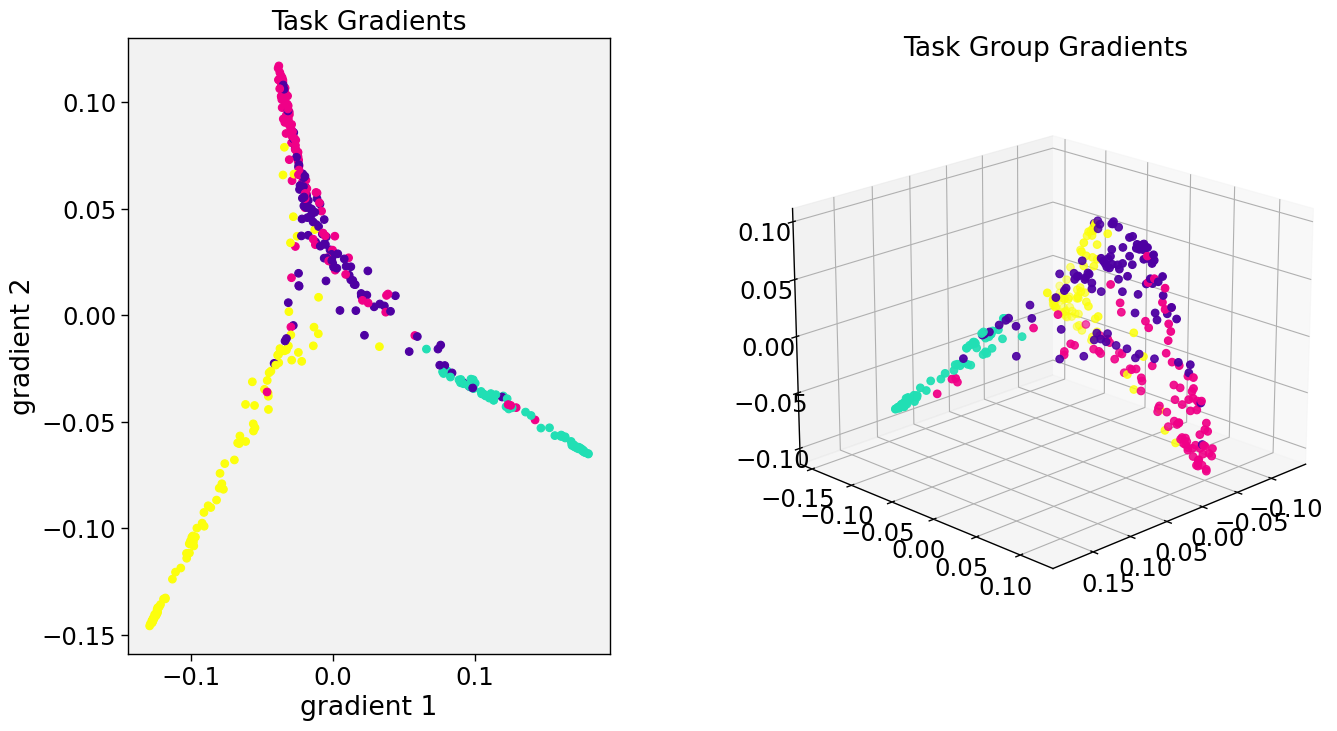

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Setting up the figure for side-by-side plots with white background
fig = plt.figure(figsize=(16, 8), facecolor='white')  # Reducing overall width and setting figure background to white

# Adjusting the 2D Scatter plot on the left
ax1 = fig.add_subplot(121, aspect=1.5, facecolor='#F2F2F2')  # Making plot background white
ax1.scatter(group_grad_df['g1'], group_grad_df['g2'], color=colors, s=30)
ax1.set_xlabel('gradient 1')
ax1.set_ylabel('gradient 2')
ax1.set_title('Task Gradients')

# Keeping the 3D Scatter plot on the right the same, with background adjustments
ax2 = fig.add_subplot(122, projection='3d', facecolor='white')  # Making plot background white
ax2.scatter(group_grad_df['g1'], group_grad_df['g2'], group_grad_df['g3']*-1, color=colors, s=30)
#ax2.set_xlabel('gradient 1')
#ax2.set_ylabel('gradient 2')
#ax2.set_zlabel('gradient 3')
ax2.set_title('Task Group Gradients')
ax2.view_init(elev=20, azim=45)

plt.subplots_adjust(wspace=0.2)  # Reducing the space between subplots

fig.savefig('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_gradients/grp/network_gradients.png')
    
plt.show()

In [26]:
# Print out paths for verification (optional)
for subj in sub_class_list:
    print(f"Plot path for Subject {subj.subject_number}: {subj.plot_path}")

Plot path for Subject 001: /pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/task_gradients/sub/001
Plot path for Subject 002: /pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/task_gradients/sub/002
Plot path for Subject 004: /pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/task_gradients/sub/004
Plot path for Subject 005: /pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/task_gradients/sub/005
Plot path for Subject 006: /pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/task_gradients/sub/006
Plot path for Subject 008: /pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/task_gradients/sub/008
Plot path for Subject 009: /pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/task_gradients/sub/009
Plot path for Subject 010: /pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/task_gradients/sub/010
Plot pat

In [44]:
from brainspace.gradient import GradientMaps
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from brainspace.null_models import SurrogateMaps
import seaborn as sns


def align_subs(data):
    
    global group_grads
    
    main_mat_list = create_func_mat(data.main_mat)
    replace_mat_list =  create_func_mat(data.replace_mat)
    suppress_mat_list = create_func_mat(data.suppress_mat)
    clear_mat_list = create_func_mat(data.clear_mat)
    
    gj = GradientMaps(approach='dm', kernel='normalized_angle', alignment='procrustes', random_state=1)
    gj_out_main = gj.fit(np.array(main_mat_list), reference = group_grads.aligned_[0])
    #print('finished main alignment for: ' +  data.name)
    
    gj = GradientMaps(approach='dm', kernel='normalized_angle', alignment='procrustes', random_state=1)
    gj_out_replace = gj.fit(np.array(replace_mat_list), reference =group_grads.aligned_[1])
    #print('finished replace alignment for: ' +  data.name)
    
    gj = GradientMaps(approach='dm', kernel='normalized_angle', alignment='procrustes', random_state=1)
    gj_out_suppress = gj.fit(np.array(suppress_mat_list), reference = group_grads.aligned_[2])
    #print('finished suppress alignment for: ' +  data.name)
    
    gj = GradientMaps(approach='dm', kernel='normalized_angle', alignment='procrustes', random_state=1)
    gj_out_clear = gj.fit(np.array(clear_mat_list), reference = group_grads.aligned_[3])
    #print('finished clear alignment for: ' +  data.name)
        
    data.main_aligned = gj_out_main.aligned_
    data.replace_aligned = gj_out_replace.aligned_
    data.suppress_aligned = gj_out_suppress.aligned_
    data.clear_aligned = gj_out_clear.aligned_
    
    return data


# Align gradients for each subject
from timeit import default_timer as timer
start = timer()
sub_class_list = list(map(align_subs, sub_class_list))
end = timer()
print(end - start)

# Function to process gradients and save plots
def process_grads(sub_class, op):
    if op == 'main':
        df = sub_class.main_aligned
    elif op == 'replace':
        df = sub_class.replace_aligned
    elif op == 'suppress':
        df = sub_class.suppress_aligned
    elif op == 'clear':
        df = sub_class.clear_aligned

    op_mat = sub_class.df1

    filepath = sub_class.plot_path

    rc_g1 = df[:, 0]
    rc_g2 = df[:, 1]
    rc_g3 = df[:, 2]

    Y = np.stack((rc_g1, rc_g2, rc_g3)).T

    fig = plt.figure(figsize=(8.5, 5.5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    colors = sub_class.colors

    ax1.scatter(Y[:, 0], Y[:, 1], c=Y[:, 1], cmap='jet_r')
    ax2.scatter(Y[:, 0], Y[:, 1], c=colors)

    fig.tight_layout()
    fig.savefig(f'{filepath}/{op}_grad_axes.png')

    plt.clf()

    # Assuming plot_3Dfigure is a defined function elsewhere in your code
    plot_3Dfigure(Y, colors, net=True, filepath=f'{filepath}/{op}_network_')
    plot_3Dfigure(Y, colors, filepath=f'{filepath}/{op}')

    grads = pd.DataFrame(Y)
    grads.columns = ['g1', 'g2', 'g3']
    df_grads = pd.concat([op_mat, grads], axis=1)
    sub_grads = df_grads[['Subtype', 'g1', 'g2', 'g3']].reset_index()

    N = int(op_mat.shape[0])

    if N == 360:
        grad_nums = [list(itertools.repeat(i, int(360/20))) for i in range(1, 21)]
        grad_nums = list(pd.DataFrame(np.array(grad_nums)).melt().sort_values('value')['value'])
    else:
        rounded = round(N * 0.05)
        num_bins = trunc(N / rounded)
        subtract = num_bins * rounded
        num_in_added_bin = op_mat.shape[0] - subtract
        bin_list = [i for i in range(1, int(num_bins) + 1) for j in range(rounded)]
        grad_nums = bin_list + [int(num_bins + 1)] * int(num_in_added_bin)

    g1_new_order = sub_grads[['index', 'Subtype', 'g1']].sort_values(by='g1')
    g1_new_order['grad'] = grad_nums
    g1_new_order['index_new'] = list(range(0, N))

    g2_new_order = sub_grads[['index', 'Subtype', 'g2']].sort_values(by='g2')
    g2_new_order['grad'] = grad_nums
    g2_new_order['index_new'] = list(range(0, N))

    g3_new_order = sub_grads[['index', 'Subtype', 'g3']].sort_values(by='g3')
    g3_new_order['grad'] = grad_nums
    g3_new_order['index_new'] = list(range(0, N))

    if op == 'main':
        sub_class.main_grads_processed = g1_new_order, g2_new_order, g3_new_order
    elif op == 'replace':
        sub_class.replace_grads_processed = g1_new_order, g2_new_order, g3_new_order
    elif op == 'suppress':
        sub_class.suppress_grads_processed = g1_new_order, g2_new_order, g3_new_order
    elif op == 'clear':
        sub_class.clear_grads_processed = g1_new_order, g2_new_order, g3_new_order

    return sub_class

from timeit import default_timer as timer
from functools import partial

for j in ['main', 'replace', 'suppress', 'clear']:
    sub_class_list = *map(partial(process_grads, op=j), sub_class_list),

10.829013333888724


NameError: name 'plot_3Dfigure' is not defined

<Figure size 850x550 with 0 Axes>

In [ ]:
import inspect
# Viewing the source code of the function
#print(inspect.getsource(get_new_mats))

In [ ]:

def create_new_orders(data):
    
    main = data.main_grads_processed
    replace = data.replace_grads_processed
    suppress = data.suppress_grads_processed
    clear = data.clear_grads_processed
    
    g1_new_orders=[]
    g2_new_orders=[]
    g3_new_orders=[]
    for i in main, replace, suppress, clear:
  
        N = 360

        g1 = i[0]
        g2 = i[1]
        g3 = i[2]

        grad_color_maps_r = get_color_maps('jet_r', N, int(N/N))
        grad_color_maps = get_color_maps('jet', N, int(N/N))
        # add color maps to gradient dfs
        g1_new_order = pd.merge(g1, grad_color_maps, on='index_new')
        g2_new_order = pd.merge(g2, grad_color_maps, on='index_new')
        g3_new_order = pd.merge(g3, grad_color_maps, on='index_new')
        
        op_names = i[0].name

        g1_new_order['ops'] = op_names
        g1_new_order['gradient'] = 1
        g1_new_order.name = op_names

        g2_new_order['ops'] = op_names
        g2_new_order['gradient'] = 2
        g2_new_order.name = op_names

        g3_new_order['ops'] = op_names
        g3_new_order['gradient'] = 3
        g3_new_order.name = op_names
        
        g1_new_orders.append(g1_new_order)
        g2_new_orders.append(g2_new_order)
        g3_new_orders.append(g3_new_order)
    
    grad1_all_ops = pd.concat(g1_new_orders)
    grad2_all_ops = pd.concat(g2_new_orders)
    grad3_all_ops = pd.concat(g3_new_orders)
    
    return grad1_all_ops, grad2_all_ops, grad3_all_ops


def grouped_grads(data):

    grad_ops_list = []
    grad_grad_list = []
    grad_sub_list = []

    grouped_grad = data.groupby(['ops', 'grad', 'Subtype']).count()

    for i in range(0,grouped_grad.shape[0], 1):
        grad_ops_list.append(grouped_grad.index[i][0])
        grad_grad_list.append(grouped_grad.index[i][1])
        grad_sub_list.append(grouped_grad.index[i][2])


    grouped_grad = grouped_grad.reset_index(drop=True)[['index']].rename({'index':'count'},axis=1)
    grouped_grad['ops'] = grad_ops_list
    grouped_grad['grads'] = grad_grad_list
    grouped_grad['subs'] = grad_sub_list
    
    return(grouped_grad)

    
def comb_grads(data, op):
    
    x1 = data.grad1_all_ops.query('ops == '+'"'+op+'"'+'')[['index', 'Subtype', 'g1']]
    x2 = data.grad2_all_ops.query('ops == '+'"'+op+'"'+'')[['index', 'g2']]
    x3 = data.grad3_all_ops.query('ops == '+'"'+op+'"'+'')[['index', 'g3']]

    merged_grads = pd.merge(x1, x2, on ='index')
    merged_grads = pd.merge(merged_grads, x3, on ='index').sort_values('index').reset_index(drop=True)
    
    if op == "main":
        data.main_grads = merged_grads 
    elif op == "replace":
        data.replace_grads = merged_grads 
    elif op == "suppress":
        data.suppress_grads = merged_grads 
    elif op == "clear":
        data.clear_grads = merged_grads 
    
    return data

def get_all_grad_ops(data, g):
    
    grad_all = pd.merge(data.main_grads[['index', g]], data.replace_grads[['index', g]], on = 'index')
    grad_all = pd.merge(grad_all, data.suppress_grads[['index', g]], on = 'index')
    grad_all = pd.merge(grad_all, data.clear_grads[['index', g]], on = 'index')
    grad_all.columns = ['index', 'maintain', 'replace', 'suppress', 'clear']
    grad_all_melt = grad_all.melt(id_vars=['index']).rename({'variable':'ops', 'value':'gradient'}, axis =1)
    
    if g == 'g1':
        data.g1_all = grad_all
        data.g1_all_melt = grad_all_melt
    elif g == 'g2':
        data.g2_all = grad_all
        data.g2_all_melt = grad_all_melt
    elif g == 'g3':
        data.g3_all = grad_all
        data.g3_all_melt = grad_all_melt

    return data


for i in range(len(sub_class_list)):
    for j in range(3):
        sub_class_list[i].main_grads_processed[j].name = 'main'
        sub_class_list[i].replace_grads_processed[j].name = 'replace'
        sub_class_list[i].suppress_grads_processed[j].name = 'suppress'
        sub_class_list[i].clear_grads_processed[j].name = 'clear'

for i in range(len(sub_class_list)):
    sub_class_list[i].grad1_all_ops, sub_class_list[i].grad2_all_ops, sub_class_list[i].grad3_all_ops = create_new_orders(sub_class_list[i])
    sub_class_list[i].grouped_grad_1  = grouped_grads(sub_class_list[i].grad1_all_ops)
    sub_class_list[i].grouped_grad_2 = grouped_grads(sub_class_list[i].grad2_all_ops)
    sub_class_list[i].grouped_grad_3  = grouped_grads(sub_class_list[i].grad3_all_ops)


for j in ['main', 'replace', 'suppress', 'clear']:
    sub_class_list = *map(partial(comb_grads, op=j), sub_class_list),
    
for j in ['g1', 'g2', 'g3']:
    sub_class_list = *map(partial(get_all_grad_ops, g=j), sub_class_list),


In [ ]:
for i in range(len(sub_class_list)):
    sub_number = sub_class_list[i].subject_number

    sub_class_list[i].g1_all['sub'] = sub_number
    sub_class_list[i].g2_all['sub'] = sub_number
    sub_class_list[i].g3_all['sub'] = sub_number

    sub_class_list[i].g1_all.to_csv(os.path.join(sub_class_list[i].plot_path, 'g1_all_ops.csv'))
    sub_class_list[i].g2_all.to_csv(os.path.join(sub_class_list[i].plot_path, 'g2_all_ops.csv'))
    sub_class_list[i].g3_all.to_csv(os.path.join(sub_class_list[i].plot_path, 'g3_all_ops.csv'))

In [ ]:
import glob
import re
import pandas as pd

# Define the pattern to match files
pattern = '/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/task_gradients/sub/*/g*_all_ops.csv'

# Use glob to find all files that match the pattern
file_list = sorted(glob.glob(pattern))

# Initialize an empty list to store DataFrames
dataframes = []

for file in file_list:
    # Extract subject ID from the file path
    subject_id = re.search(r'/sub/([^/]+)/', file).group(1)
    
    # Extract the part of the filename before '_all_ops'
    grad = re.search(r'(g\d+)_all_ops', file).group(1)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file)
    
    # Add the subject ID as a new column
    df['SubID'] = subject_id
    
    # Add the 'grad' as a new column
    df['grad'] = grad
    
    # Append the DataFrame to the list
    dataframes.append(df)

# Combine all DataFrames into one, if necessary
combined_df = pd.concat(dataframes, ignore_index=True)

# Now 'combined_df' contains all data with a 'SubID' and 'grad' column indicating the subject ID and the gradient respectively.
# Adjusting the DataFrame by dropping and reordering columns as required
combined_df = combined_df.drop(['Unnamed: 0', 'sub'], axis=1, errors='ignore')  # errors='ignore' handles cases where these columns might not exist
combined_df = combined_df[['index', 'SubID', 'maintain', 'replace', 'suppress', 'clear', 'grad']]

# combined_df now includes the 'grad' column with the part of the filename you were interested in.

combined_df_g1 = combined_df.query('grad == "g1"').drop('grad', axis=1).reset_index(drop=True)
combined_df_g1.columns = ['index', 'SubID', 'maintain_g1', 'replace_g1', 'suppress_g1', 'clear_g1']

combined_df_g2 = combined_df.query('grad == "g2"').drop('grad', axis=1).reset_index(drop=True)
combined_df_g2.columns = ['index', 'SubID', 'maintain_g2', 'replace_g2', 'suppress_g2', 'clear_g2']

combined_df_g3 = combined_df.query('grad == "g3"').drop('grad', axis=1).reset_index(drop=True)
combined_df_g3.columns = ['index', 'SubID', 'maintain_g3', 'replace_g3', 'suppress_g3', 'clear_g3']

combined_all = pd.concat([combined_df_g1, 
                          combined_df_g2.drop(['index', 'SubID'], axis=1), 
                          combined_df_g3.drop(['index', 'SubID'], axis=1)], axis=1)

combined_all = combined_all[['index', 'SubID', 'maintain_g1', 'maintain_g2', 'maintain_g3', 'replace_g1', 'replace_g2', 'replace_g3', 
              'suppress_g1', 'suppress_g2', 'suppress_g3', 'clear_g1', 'clear_g2', 'clear_g3']]

wm_networks = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_gradients/wm_networks.csv')
wm_networks = wm_networks.reset_index()

combined_all = pd.merge(wm_networks, combined_all, on='index').sort_values(['SubID', 'index'])
combined_all['SubID'] = combined_all['SubID'].astype(float)

In [ ]:
leiden_networks = (pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/leiden_network_glasser_regions.csv')
                   .iloc[:, :2])

leiden_networks.columns = ['parcel', 'network']   

vn_parcels = leiden_networks.query('network == "Visual Network"').parcel.to_list()
smn_parcels = leiden_networks.query('network == "Somatomotor Network"').parcel.to_list()
fpcn_parcels = leiden_networks.query('network == "Frontoparietal Network"').parcel.to_list()
dmn_parcels = leiden_networks.query('network == "Default Mode Network"').parcel.to_list()

In [ ]:
from glob import glob 

g1_path = '/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/task_gradients/sub/*/g1_all_ops.csv'
g2_path = '/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/task_gradients/sub/*/g2_all_ops.csv'
g3_path = '/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/task_gradients/sub/*/g3_all_ops.csv'

def sub_grads(paths, grad):
    g_dfs=[]
    for i in sorted(sorted(glob(paths, recursive = True))): 
        g_dfs.append((pd.read_csv(i).iloc[:, 2:]))
    sub_g = pd.concat(g_dfs).assign(gradient=grad)

    
    return sub_g

sub_g_list=[]
for i, j in zip([g1_path, g2_path, g3_path], range(1,4)):
    sub_g_list.append(sub_grads(i, j))

sub_gs=pd.concat(sub_g_list)


In [ ]:
z_data = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/ClearMem_Z_Average.csv')

rrs_data = z_data[['SubID','RRS_total', 'RRS_depression', 'RRS_brooding', 'RRS_reflection']]

z_data = z_data[['SubID', 'z_ave', 'PSWQ_total', 'WBSI_total']]
z_data['sub'] = z_data['SubID']
z_data_no_19 = z_data

In [ ]:
def new_grad_names(data, name):
    new_column_names = {col: name + str(col) for col in data.columns}
    data = data.rename(columns=new_column_names)
    return data

def long_wide_grads(data, sub, grad):
    s_g_main = data.query('sub =='+str(sub)+' and gradient =='+str(grad))[['maintain']].T
    s_g_replace = data.query('sub =='+str(sub)+' and gradient =='+str(grad))[['replace']].T
    s_g_suppress = data.query('sub =='+str(sub)+' and gradient =='+str(grad))[['suppress']].T
    s_g_clear = data.query('sub =='+str(sub)+' and gradient =='+str(grad))[['clear']].T

    s_g_main = new_grad_names(s_g_main, 'g'+str(grad)+'_main_').reset_index(drop=True)
    s_g_replace = new_grad_names(s_g_replace, 'g'+str(grad)+'_replace_').reset_index(drop=True)
    s_g_suppress = new_grad_names(s_g_suppress, 'g'+str(grad)+'_suppress_').reset_index(drop=True)
    s_g_clear = new_grad_names(s_g_clear, 'g'+str(grad)+'_clear_').reset_index(drop=True)

    wide_g = pd.concat([s_g_main, s_g_replace, s_g_suppress, s_g_clear], axis=1)
    
    return wide_g

all_sub_gs_wide = []
for i in sub_gs['sub'].unique():
    wide_sub_gs = []
    for j in range(1,4):
        wide_sub_gs.append(long_wide_grads(sub_gs, i, j))     
    final = pd.concat(wide_sub_gs, axis=1).assign(sub = i)
    all_sub_gs_wide.append(final)
    
wide_gs = pd.concat(all_sub_gs_wide)

In [ ]:
def mah_cent_dist(data, sub, op):
    
    data_sub = (data
                .query('sub =='+str(sub))[['sub', 'gradient', op]].reset_index()
                .pivot(index=['index', 'sub'], columns='gradient', values=op)
               ).reset_index()
   
    from scipy.spatial.distance import mahalanobis

    # Generate a random data frame with 95 rows and 3 columns
    df = data_sub.iloc[:, 2:]

    # Calculate the mean vector for each column
    mu = df.mean()

    cov = df.cov()
    # Calculate the inverse of the covariance matrix
    inv_cov = np.linalg.inv(cov)

    # Calculate the pairwise Mahalanobis distance between each row and the mean vector
    distances = []
    for index, row in df.iterrows():
        distance = mahalanobis(row, mu, inv_cov)
        distances.append(distance)

    # Convert the distances list to a pandas series and add it as a new column to the data frame
    df['md'] = pd.DataFrame(distances, index=df.index)
    df = df.assign(op = op, sub=sub, parcel=data_sub['index'])
    df = df.assign(cent_mah_md = df['op'] +'_'+ df['parcel'].astype(str) + '_md')
    df = df[['cent_mah_md', 'sub', 'op', 'md']]
    return df


def mah_dist(data, sub, op, parcels, network):
    
    data_sub = (data
                .query('sub =='+str(sub))[['sub', 'gradient', op]].reset_index()
                .pivot(index=['index', 'sub'], columns='gradient', values=op)
               ).reset_index().iloc[parcels]
   
    from scipy.spatial.distance import mahalanobis

    # Generate a random data frame with 95 rows and 3 columns
    df = data_sub.iloc[:, 2:]

    # Calculate the mean vector for each column
    mu = df.mean()

    cov = df.cov()
    # Calculate the inverse of the covariance matrix
    inv_cov = np.linalg.inv(cov)

    # Calculate the pairwise Mahalanobis distance between each row and the mean vector
    distances = []
    for index, row in df.iterrows():
        distance = mahalanobis(row, mu, inv_cov)
        distances.append(distance)

    # Convert the distances list to a pandas series and add it as a new column to the data frame
    df['md'] = pd.DataFrame(distances, index=df.index)
    df['md'] = df['md']*-1
    df = df.assign(op = op, sub=sub, parcel=data_sub['index'], net=network)
    df = df.assign(net_mah_md = df['op'] +'_'+ df['parcel'].astype(str) + '_md_'+df['net'])
    df = df[['net_mah_md', 'parcel', 'sub', 'op', 'md']]
    return df

cent_mah_dist =[]
for i in sub_gs['sub'].unique():
    for j in ['maintain', 'replace', 'suppress', 'clear']:
            cent_mah_dist.append(mah_cent_dist(sub_gs, i, j))
            
cent_mah = (pd.concat(cent_mah_dist)
           .pivot(index='sub', columns='cent_mah_md', values='md').reset_index())

net_mah_dist =[]
for i in sub_gs['sub'].unique():
    for j in ['maintain', 'replace', 'suppress', 'clear']:
        for k,l in zip([vn_parcels, smn_parcels, fpcn_parcels,dmn_parcels], 
                       ['vn', 'smn', 'fpcn','dmn']):
            net_mah_dist.append(mah_dist(sub_gs, i, j, k, l))
            
net_mah = (pd.concat(net_mah_dist)
           .pivot(index='sub', columns='net_mah_md', values='md').reset_index())

def md_mean(data, op, parcels, net):
    means = (data.filter(regex='md')
             .filter(regex=op)
             .filter(regex=net)
             .sum(axis=1)
            )#.rename(columns=lambda x: x.replace(op+'_md_', '')).iloc[:, parcels].mean(axis=1)
    
    data[op+'_'+net+'_dispersion_md'] = means
    return data

for i in ['main', 'replace', 'suppress', 'clear']:
    for j,k in zip([vn_parcels, smn_parcels, fpcn_parcels, dmn_parcels], ['vn', 'smn', 'fpcn', 'dmn']):
        
        md_mean(net_mah, i, j, k)
        
sub_within_network_disp = net_mah.filter(regex='sub|dispersion').rename({'sub':'SubID'}, axis=1)

In [ ]:
def get_modularity(data, op):
    
    from scipy.stats import spearmanr, pearsonr
    from scipy import stats
    from scipy.spatial import distance
    import math
    import networkx as nx
    import numpy as np
    
        #=======================================================================================================#
    def hadamard(nearest):
        """
        This function converts a directed adjacency matrix to a matrix of Hadamard distances
        based on the overlap of neighbors. The implementation is efficiently based
        on matrix multiplications.
        A an N-by-N adjacency matrix holding TRUE or 1 values for edges an N-by-N matrix with
        the Hadamard coefficient of neighbor overlap.
        """

        common = nearest.T @ nearest
        ranks = np.outer(np.diag(common), np.ones(nearest.shape[0]))
        neighborUnion = ranks + ranks.T - common
        G = common / neighborUnion
        np.fill_diagonal(G, 0)

        return G

    #=======================================================================================================#
    def topMax(x, N):
        """
        find Nth largest number in an array
        """

        L = len(x)
        assert N < L, 'Number of neighbors cannot be larger than length of data'

        while L != 1:
            initial_guess = x[0]
            top_list = x[x > initial_guess]
            bottom_list = x[x < initial_guess]

            topL = len(top_list)
            bottomL = len(bottom_list)

            if (topL < N) and (L - bottomL >= N):
                x = initial_guess
                break

            if topL >= N:
                x = top_list
            else:
                x = bottom_list
                N = N - L + bottomL
            L = len(x)

        return x

    #=======================================================================================================#
    def bottomMin(x, N):
        """
        find Nth smallest number in an array
        """

        return np.round(topMax(x, len(x) - N + 1))

    #=======================================================================================================#
    def find_neighbors(D, k):
        """
        Tranform distance matrix to binary k-nearest neighbors graph
        """

        nearest = np.zeros(D.shape)
        for i in range(nearest.shape[1]):
            nearest[:,i] = np.round(D[:,i]) <= bottomMin(np.round(D[:,i]), k)


        return nearest

    df = data.filter(regex=op)
    # Assuming your DataFrame is named df and has columns 'maintain_g1', 'maintain_g2', 'maintain_g3'
    data_columns = df.columns
    
   #mahal = '''
    ########
        # Calculate the inverse of the covariance matrix
    from scipy.linalg import inv  # Ensure this import statement is included

    cov_matrix = np.cov(df[data_columns].values, rowvar=False)
    inv_cov_matrix = inv(cov_matrix)

    # Function to calculate the Mahalanobis distance matrix
    def mahalanobis_matrix(data, inv_cov_matrix):
        n = data.shape[0]
        mahal_matrix = np.zeros((n, n))

        for i in range(n):
            for j in range(i, n):
                diff = data[i] - data[j]
                dist = np.dot(np.dot(diff, inv_cov_matrix), diff.T)
                mahal_matrix[i, j] = np.sqrt(dist)
                mahal_matrix[j, i] = mahal_matrix[i, j]  # Since the matrix is symmetric

        return mahal_matrix

    # Calculate the Mahalanobis distance matrix
    data_values = df[data_columns].values
    mahal_matrix = mahalanobis_matrix(data_values, inv_cov_matrix)
    # If you want to put this matrix into a DataFrame (optional):
    mahal_df = pd.DataFrame(mahal_matrix, index=df.index, columns=df.index)
    ########
    #'''
        
    #X_Z =  np.array(df)
    #D, rho = spearmanr(np.array(X_Z), axis=1)
    #D = np.round((X_Z.shape[1]**3 - X_Z.shape[1]) * (1 - D) / 6).astype(np.int)
    #D = rho
    D = np.array(mahal_df)
    #k = np.ceil(math.sqrt(D.shape[0]))

    #nearest = find_neighbors(D, k + 1)
    #G = hadamard(nearest)  
    adjacency_matrix = np.array(mahal_df)
    gframe = pd.DataFrame(D)
    #gframe = reduce_memory_usage(gframe)
    graph = Graph.Weighted_Adjacency(gframe.values.tolist(), mode=ADJ_UNDIRECTED, attr="weight")
    G = graph.to_networkx()
    
    def calculate_modularity_and_contributions(adjacency_matrix, communities):
        
        m = adjacency_matrix.sum() / 2.0  # Total weight of edges in the graph, for weighted networks
        total_modularity = 0.0
        community_contributions = []

        for community in communities:
            L_c = 0.0  # Total weight of all the edges within a community, for weighted networks
            D_c = 0.0  # Total degree (sum of edge weights) of the nodes in the community
            for i in community:
                for j in community:
                    L_c += adjacency_matrix[i, j]
                D_c += adjacency_matrix[i].sum()

            # Modularity contribution from this community
            contribution = (L_c / (2 * m)) - (D_c / (2 * m)) ** 2
            community_contributions.append(abs(contribution))
            total_modularity += abs(contribution)

        return total_modularity, community_contributions

    communities = np.array(data.Subtype)

    import numpy as np

    # Assuming `communities` is a NumPy array where each element is the community label of a node
    unique_communities = np.unique(communities)
    community_lists = [np.where(communities == community)[0].tolist() for community in unique_communities]

    # Now you can use `community_lists` with the function
    total_modularity, contributions = calculate_modularity_and_contributions(adjacency_matrix, community_lists)

    return total_modularity, contributions
    
def get_mods(data, sub):

    group_mod = []

    for i in ['maintain', 'replace', 'suppress', 'clear']:
        group_mod.append(get_modularity(data, i))

    def clean_mods(group_mod):

        op_mods=[]
        for i in range(len(group_mod)):
            op_mods.append(group_mod[i][0])

        op_mods=pd.DataFrame([op_mods]).rename({0:'main_mod',
                                                1:'replace_mod',
                                                2:'suppress_mod',
                                                3:'clear_mod',
                                               }, axis=1)

        op_net_mods=[]
        for i in range(len(group_mod)):
            op_net_mods.append(group_mod[i][1])

        main_mods=pd.DataFrame([op_net_mods[0]])
        main_mods.columns = ['vn_main_mod', 'smn_main_mod', 'fpcn_main_mod', 'dmn_main_mod']

        replace_mods=pd.DataFrame([op_net_mods[1]])
        replace_mods.columns = ['vn_replace_mod', 'smn_replace_mod', 'fpcn_replace_mod', 'dmn_replace_mod']

        suppress_mods=pd.DataFrame([op_net_mods[2]])
        suppress_mods.columns = ['vn_suppress_mod', 'smn_suppress_mod', 'fpcn_suppress_mod', 'dmn_suppress_mod']

        clear_mods=pd.DataFrame([op_net_mods[3]])
        clear_mods.columns = ['vn_clear_mod', 'smn_clear_mod', 'fpcn_clear_mod', 'dmn_clear_mod']

        all_mods = pd.concat([op_mods, main_mods, replace_mods, suppress_mods, clear_mods], axis=1)

        return all_mods

    all_mods = clean_mods(group_mod)
    all_mods_cols = ['SubID'] + all_mods.columns.to_list()
    all_mods = all_mods.assign(SubID = sub)[all_mods_cols]

    return all_mods

In [ ]:
sub_mods =[]
for i in combined_all.SubID.unique():
    #print(i)
    sub_mod_grads = combined_all.query('SubID == @i')
    sub_mods.append(get_mods(sub_mod_grads, i))

sub_mods_df = pd.concat(sub_mods).reset_index(drop=True) 
sub_mods_df['SubID'] = sub_mods_df.SubID.astype(int)

In [ ]:
from scipy.stats import spearmanr, pearsonr
from scipy import stats
from scipy.spatial import distance
import math
import networkx as nx
import numpy as np
from igraph import *

    #=======================================================================================================#
def hadamard(nearest):
    """
    This function converts a directed adjacency matrix to a matrix of Hadamard distances
    based on the overlap of neighbors. The implementation is efficiently based
    on matrix multiplications.
    A an N-by-N adjacency matrix holding TRUE or 1 values for edges an N-by-N matrix with
    the Hadamard coefficient of neighbor overlap.
    """

    common = nearest.T @ nearest
    ranks = np.outer(np.diag(common), np.ones(nearest.shape[0]))
    neighborUnion = ranks + ranks.T - common
    G = common / neighborUnion
    np.fill_diagonal(G, 0)

    return G

#=======================================================================================================#
def topMax(x, N):
    """
    find Nth largest number in an array
    """

    L = len(x)
    assert N < L, 'Number of neighbors cannot be larger than length of data'

    while L != 1:
        initial_guess = x[0]
        top_list = x[x > initial_guess]
        bottom_list = x[x < initial_guess]

        topL = len(top_list)
        bottomL = len(bottom_list)

        if (topL < N) and (L - bottomL >= N):
            x = initial_guess
            break

        if topL >= N:
            x = top_list
        else:
            x = bottom_list
            N = N - L + bottomL
        L = len(x)

    return x

#=======================================================================================================#
def bottomMin(x, N):
    """
    find Nth smallest number in an array
    """

    return np.round(topMax(x, len(x) - N + 1))

#=======================================================================================================#
def find_neighbors(D, k):
    """
    Tranform distance matrix to binary k-nearest neighbors graph
    """

    nearest = np.zeros(D.shape)
    for i in range(nearest.shape[1]):
        nearest[:,i] = np.round(D[:,i]) <= bottomMin(np.round(D[:,i]), k)


    return nearest

In [ ]:
from scipy.stats import spearmanr, pearsonr
from scipy import stats
from scipy.spatial import distance
import math
import networkx as nx
import numpy as np
from igraph import *

    #=======================================================================================================#
def hadamard(nearest):
    """
    This function converts a directed adjacency matrix to a matrix of Hadamard distances
    based on the overlap of neighbors. The implementation is efficiently based
    on matrix multiplications.
    A an N-by-N adjacency matrix holding TRUE or 1 values for edges an N-by-N matrix with
    the Hadamard coefficient of neighbor overlap.
    """

    common = nearest.T @ nearest
    ranks = np.outer(np.diag(common), np.ones(nearest.shape[0]))
    neighborUnion = ranks + ranks.T - common
    G = common / neighborUnion
    np.fill_diagonal(G, 0)

    return G

#=======================================================================================================#
def topMax(x, N):
    """
    find Nth largest number in an array
    """

    L = len(x)
    assert N < L, 'Number of neighbors cannot be larger than length of data'

    while L != 1:
        initial_guess = x[0]
        top_list = x[x > initial_guess]
        bottom_list = x[x < initial_guess]

        topL = len(top_list)
        bottomL = len(bottom_list)

        if (topL < N) and (L - bottomL >= N):
            x = initial_guess
            break

        if topL >= N:
            x = top_list
        else:
            x = bottom_list
            N = N - L + bottomL
        L = len(x)

    return x

#=======================================================================================================#
def bottomMin(x, N):
    """
    find Nth smallest number in an array
    """

    return np.round(topMax(x, len(x) - N + 1))

#=======================================================================================================#
def find_neighbors(D, k):
    """
    Tranform distance matrix to binary k-nearest neighbors graph
    """

    nearest = np.zeros(D.shape)
    for i in range(nearest.shape[1]):
        nearest[:,i] = np.round(D[:,i]) <= bottomMin(np.round(D[:,i]), k)


    return nearest

import numpy as np
import pandas as pd
import networkx as nx
import math
from scipy.stats import spearmanr

def compute_network_metrics(data, op, net, sub):

    df = data.filter(regex=op)
    # Assuming your DataFrame is named df and has columns 'maintain_g1', 'maintain_g2', 'maintain_g3'
    data_columns = df.columns
    
    
    #mahal = '''
    ########
        # Calculate the inverse of the covariance matrix
    from scipy.linalg import inv  # Ensure this import statement is included

    cov_matrix = np.cov(df[data_columns].values, rowvar=False)
    inv_cov_matrix = inv(cov_matrix)

    # Function to calculate the Mahalanobis distance matrix
    def mahalanobis_matrix(data, inv_cov_matrix):
        n = data.shape[0]
        mahal_matrix = np.zeros((n, n))

        for i in range(n):
            for j in range(i, n):
                diff = data[i] - data[j]
                dist = np.dot(np.dot(diff, inv_cov_matrix), diff.T)
                mahal_matrix[i, j] = np.sqrt(dist)
                mahal_matrix[j, i] = mahal_matrix[i, j]  # Since the matrix is symmetric

        return mahal_matrix

    # Calculate the Mahalanobis distance matrix
    data_values = df[data_columns].values
    mahal_matrix = mahalanobis_matrix(data_values, inv_cov_matrix)
    # If you want to put this matrix into a DataFrame (optional):
    mahal_df = pd.DataFrame(mahal_matrix, index=df.index, columns=df.index)
    ########
    #'''
        
    #X_Z =  np.array(df)
    #D, rho = spearmanr(np.array(X_Z), axis=1)
    #D = np.round((X_Z.shape[1]**3 - X_Z.shape[1]) * (1 - D) / 6).astype(np.int)
    #D = rho
    G = np.array(mahal_df)
    #k = np.ceil(math.sqrt(D.shape[0]))
    
    #nearest = find_neighbors(D, k + 1)
    #G = hadamard(nearest)  

    gframe = pd.DataFrame(G)
    #gframe = reduce_memory_usage(gframe)
    graph = Graph.Weighted_Adjacency(gframe.values.tolist(), mode=ADJ_UNDIRECTED, attr="weight")
    G = graph.to_networkx()
 
    metrics = pd.DataFrame({
        #'efficiency': nx.global_efficiency(G),
        #'local_efficiency': nx.local_efficiency(G),
        #'degree_centrality': nx.degree_centrality(G),
        'eigenvector_centrality': nx.eigenvector_centrality(G, weight='weight', max_iter=500, tol=1e-06),
        #'closeness_centrality': nx.closeness_centrality(G, distance='weight'), 
        #'pagerank' : nx.pagerank(G),  
    })
    #print(metrics)
    metrics = pd.DataFrame(metrics.sum()).T
    
    metrics.columns = [f'{op}_{net}_{i}' for i in metrics.columns]
    
    cols = ['SubID'] + metrics.columns.to_list()
    
    metrics=metrics.assign(SubID = sub)
    metrics = metrics[cols]

    return metrics

In [ ]:
sub_graph_effs =[]
for i in combined_all.SubID.unique():
    for j in ['maintain', 'replace', 'suppress', 'clear']:
        for k, l in zip(list(range(1,5)), ['vn', 'smn', 'fpcn', 'dmn']):
            sub_eff = combined_all.query('SubID == @i').query('Subtype == @k')
            sub_graph_effs.append(compute_network_metrics(sub_eff, j, l, i))
            
sub_graph_effs_df = pd.concat(sub_graph_effs).reset_index(drop=True) 
sub_graph_effs_df['SubID'] = sub_graph_effs_df.SubID.astype(int)

# Define a custom aggregation function that ignores NAs
# This function takes the first non-NA value it finds across the rows
def first_non_na(series):
    return series.dropna().iloc[0] if not series.dropna().empty else np.nan

# Group by 'SubID' and apply the custom aggregation function to each column
sub_graph_effs_df = sub_graph_effs_df.groupby('SubID', as_index=False).agg(first_non_na)

In [ ]:
def across_net_disp(subid):

    global combined_all

    df = combined_all.query(f'SubID == {subid}')

    import pandas as pd
    import numpy as np
    from scipy.spatial.distance import mahalanobis

    # List of operations
    operations = ['main', 'replace', 'suppress', 'clear']

    # Network codes and names mapping
    network_names = {
        1: 'vn',
        2: 'smn',
        3: 'fpcn',
        4: 'dmn'
    }

    # Initialize an empty DataFrame to store results
    results_df = pd.DataFrame()

    # Iterate over each operation
    for op in operations:
        # Iterate over all possible combinations of networks
        for net1 in range(1, 5):
            for net2 in range(net1 + 1, 5):
                # Filter data for each network based on operation
                df_network1 = df.query(f'Subtype == {net1}').filter(regex=f'{op}')
                df_network2 = df.query(f'Subtype == {net2}').filter(regex=f'{op}')

                # Calculate the mean vector for Network1 and Network2
                mu_network1 = df_network1.mean()
                mu_network2 = df_network2.mean()

                # Calculate the covariance matrix for Network1 and Network2
                cov_network1 = df_network1.cov()
                cov_network2 = df_network2.cov()

                # Calculate the average covariance matrix
                avg_cov = (cov_network1 + cov_network2) / 2

                if not avg_cov.empty:
                    inv_avg_cov = np.linalg.inv(avg_cov)

                    # Calculate the Mahalanobis distance between the two mean vectors using the average covariance matrix
                    distance = mahalanobis(mu_network1, mu_network2, inv_avg_cov)*-1

                    # Format result
                    sub1 = network_names[net1]
                    sub2 = network_names[net2]

                    # Prepare result for this combination and operation
                    result = pd.DataFrame([[subid, distance]], columns=['SubID', f'{op}_{sub1}_{sub2}_disp'])

                    # Append result to the results DataFrame
                    results_df = pd.concat([results_df, result], ignore_index=True)

    # Define a custom aggregation function that ignores NAs
    def first_non_na(series):
        return series.dropna().iloc[0] if not series.dropna().empty else np.nan

    results_df = results_df.groupby(['SubID'], as_index=False).agg(first_non_na)

    return results_df

In [ ]:
across_net_disp_lists = [across_net_disp(i) for i in combined_all.SubID.unique()]
across_network_disp = pd.concat(across_net_disp_lists).reset_index(drop=True)

In [ ]:
def net_ecc(subid):
    global combined_all

    df = combined_all.query(f'SubID == {subid}')

    import pandas as pd
    import numpy as np
    from scipy.spatial.distance import mahalanobis

    # List of operations
    operations = ['main', 'replace', 'suppress', 'clear']

    # Network codes and names mapping
    network_names = {
        1: 'vn',
        2: 'smn',
        3: 'fpcn',
        4: 'dmn'
    }

    # Initialize an empty DataFrame to store results
    results_df = pd.DataFrame()

    # Iterate over each operation
    for op in operations:
        # Filter data for each operation
        df_operation = df.filter(regex=f'Subtype|{op}')
        
        # Calculate the mean vector and covariance matrix for this operation
        operation_mean = df_operation.drop('Subtype', axis=1).mean()
        operation_cov = df_operation.drop('Subtype', axis=1).cov()
        inv_operation_cov = np.linalg.inv(operation_cov)

        for net_code, net_name in network_names.items():
            # Filter data for each network based on operation
            df_network = df_operation.query(f'Subtype == {net_code}').drop('Subtype', axis=1)

            distances = []

            for index, row in df_network.iterrows():
                # Calculate the Mahalanobis distance from the mean of the entire data
                distance = mahalanobis(row, operation_mean, inv_operation_cov)
                distances.append(distance)  # Square the distance to calculate eccentricity

            # Calculate the sum of squared distances
            eccentricity = sum(distances)

            # Prepare result for this network and operation
            result = pd.DataFrame([[subid, eccentricity]], columns=['SubID', f'{op}_{net_name}_eccentricity'])

            # Append result to the results DataFrame
            results_df = pd.concat([results_df, result], ignore_index=True)
            
     # Define a custom aggregation function that ignores NAs
    def first_non_na(series):
        return series.dropna().iloc[0] if not series.dropna().empty else np.nan

    results_df = results_df.groupby(['SubID'], as_index=False).agg(first_non_na)

    return results_df


In [ ]:
def op_ecc(subid):
    global combined_all

    df = combined_all.query(f'SubID == {subid}')

    import pandas as pd
    import numpy as np
    from scipy.spatial.distance import mahalanobis

    # List of operations
    operations = ['main', 'replace', 'suppress', 'clear']

    # Initialize an empty DataFrame to store results
    results_df = pd.DataFrame()

    # Iterate over each operation
    for op in operations:
        # Filter data for each operation
        df_operation = df.filter(regex=f'{op}')
        
        # Calculate the mean vector and covariance matrix for this operation
        operation_mean = df_operation.mean()
        operation_cov = df_operation.cov()
        inv_operation_cov = np.linalg.inv(operation_cov)

        for net_code, net_name in network_names.items():
            # Filter data for each network based on operation
            df_network = df_operation.query(f'op == {net_code}').drop('Subtype', axis=1)

            distances = []

            for index, row in df_network.iterrows():
                # Calculate the Mahalanobis distance from the mean of the entire data
                distance = mahalanobis(row, operation_mean, inv_operation_cov)
                distances.append(distance)  # Square the distance to calculate eccentricity

            # Calculate the sum of squared distances
            eccentricity = sum(distances)

            # Prepare result for this network and operation
            result = pd.DataFrame([[subid, eccentricity]], columns=['SubID', f'{op}_{net_name}_eccentricity'])

            # Append result to the results DataFrame
            results_df = pd.concat([results_df, result], ignore_index=True)
            
     # Define a custom aggregation function that ignores NAs
    def first_non_na(series):
        return series.dropna().iloc[0] if not series.dropna().empty else np.nan

    results_df = results_df.groupby(['SubID'], as_index=False).agg(first_non_na)

    return results_df


In [ ]:
net_ecc_lists = [net_ecc(i) for i in combined_all.SubID.unique()]
net_ecc = pd.concat(net_ecc_lists).reset_index(drop=True)

In [ ]:
def process_sub_ranges(data, sub):

    range_cols = ['maintain_g1', 'maintain_g2', 'maintain_g3', 'replace_g1', 'replace_g2',
           'replace_g3', 'suppress_g1', 'suppress_g2', 'suppress_g3', 'clear_g1',
           'clear_g2', 'clear_g3']

    def range_dif(data, sub, col):

        data = data.query('SubID == @sub')

        dif = data[col].max() - data[col].min()

        return dif 

    sub_ranges = []
    for i in range_cols:
        sub_ranges.append(range_dif(data, sub, i))

    sub_range_df = pd.DataFrame(sub_ranges).T
    sub_range_df.columns = range_cols
    sub_range_df = sub_range_df.assign(SubID = sub)
    sub_range_df = sub_range_df[['SubID'] + range_cols]
    
    return sub_range_df

sub_ranges = []
for i in combined_all.SubID.unique():
    sub_ranges.append(process_sub_ranges(combined_all, i))
    
sub_range_df = pd.concat(sub_ranges)

In [ ]:
sub_within_network_disp.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/dispersion_data/derosa_task_within_network_dispersion.csv', index=False)
net_ecc.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/dispersion_data/derosa_task_eccentricity.csv', index=False)
across_network_disp.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/dispersion_data/derosa_task_across_network_dispersion.csv', index=False)
sub_mods_df.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/dispersion_data/derosa_task_network_modularity.csv', index=False)
sub_graph_effs_df.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/dispersion_data/derosa_task_network_eigcent.csv', index=False)
sub_range_df.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/task_conn/dispersion_data/derosa_task_gradient_range.csv', index=False)


In [ ]:
#!jupyter nbconvert --to script process_conn_task.ipynb